In [1]:
using QuantumCumulants
using OrdinaryDiffEq, ModelingToolkit
using DifferentialEquations
using PyPlot
using NPZ
import LinearAlgebra as la
# Define parameters
multiplier = 1e9
M_1 = 10900
M_3 = 1750
# M_3 = 0.175
y1 = 2*pi*2.94e-3*multiplier
y3 = 1.76e-2*multiplier

@cnumbers ω1 ω2 ω3 g1 g2 γ1 γ2 γ3 Ω1 Ω2 Ω3  # 2-magnon, 2-photon
h1 = FockSpace(:cavity);h2 = FockSpace(:cavity);h3 = FockSpace(:cavity)
h=h1⊗h2⊗h3
# Define the fundamental operators
@qnumbers b1::Destroy(h,1) b2::Destroy(h,2) b3::Destroy(h,3)
#            magnon PY          resonator        magnon YIG

Ham = ω1*(b1'*b1) + ω2*(b2'*b2) + ω3*(b3'*b3) + g1*((b1'*b2)+(b2'*b1)) + g2*((b3'*b2)+(b2'*b3)) + Ω1*( b1'+b1) + Ω2*(b2'+b2) + Ω3*(b3'+b3)
# Collapse operators
J = [b1,b2,b3]; rates = [2γ1,2γ2,2γ3]
# Derive a set of equations
ops = [b1,b2,b3]; eqs = meanfield(ops,Ham,J;rates=rates,order=1)


∂ₜ(⟨b1⟩) = (0 - 1im)*Ω1 + (0 - 1im)*g1*⟨b2⟩ + (0 - 1im)*ω1*⟨b1⟩ - γ1*⟨b1⟩
∂ₜ(⟨b2⟩) = (0 - 1im)*Ω2 + (0 - 1im)*g1*⟨b1⟩ + (0 - 1im)*ω2*⟨b2⟩ + (0 - 1im)*g2*⟨b3⟩ - γ2*⟨b2⟩
∂ₜ(⟨b3⟩) = (0 - 1im)*Ω3 + (0 - 1im)*g2*⟨b2⟩ + (0 - 1im)*ω3*⟨b3⟩ - γ3*⟨b3⟩


In [2]:
# Complete equations
eqs_completed = complete(eqs);
@named sys = ODESystem(eqs_completed);
A = calculate_jacobian(sys); B=[eqs_completed[1].rhs.dict[Ω1] * Ω1; eqs_completed[2].rhs.dict[Ω2] * Ω2; eqs_completed[3].rhs.dict[Ω3] * Ω3];
Ainv=inv(A); X=Ainv*B; b1=X[1]; b2=X[2]; b3=X[3];

A

3×3 Matrix{Num}:
 (0-1im)*ω1 - γ1       (0-1im)*g1                0
      (0-1im)*g1  (0-1im)*ω2 - γ2       (0-1im)*g2
               0       (0-1im)*g2  (0-1im)*ω3 - γ3

(161,)
(161, 2)


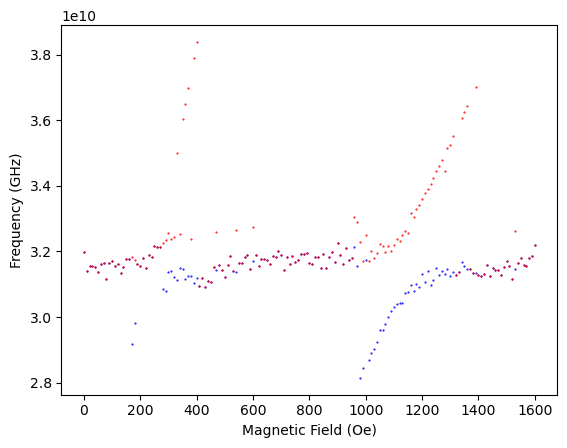

In [3]:
using DelimitedFiles

type = "strong50"
root = "C:\\Users\\freak\\OneDrive\\Documents\\core\\Projects\\cavityCoupling\\data"
# Read the CSV file into a DataFrame
# file_path = joinpath(root,"strong_peaks_widths.csv")
file_path = joinpath(root, "$type"*"_peaks_widths.csv")
file_path_full = joinpath(root,"$type.csv")
df = readdlm(file_path, ',', Float64, '\n',skipstart=1)
full_data = readdlm(file_path_full,',',Float64,'\n')

# Display the first few rows of the DataFrame
frequencies = full_data[2:end,1] * 2e9 * pi;
s21 = full_data[2:end,2:end];
locs = df[:,1:2] * 2e9 * pi;
locs = sort(locs, dims=2)
Hlist = full_data[1,2:end];
println(size(Hlist))
println(size(locs))
plot(Hlist, locs[:,1], "bo", markersize=.5);plot(Hlist, locs[:,2], "ro", markersize=.5);
xlabel("Magnetic Field (Oe)"); ylabel("Frequency (GHz)");

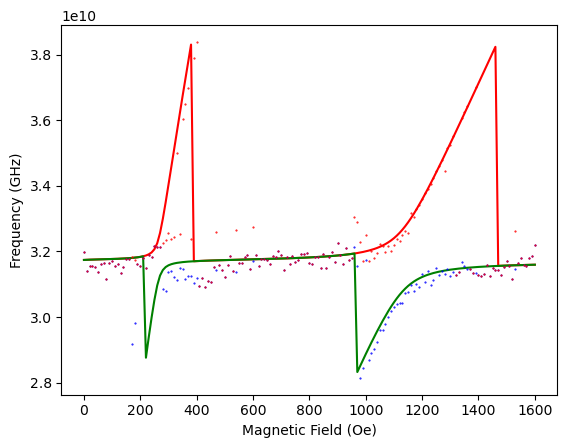

"C:\\Users\\freak\\OneDrive\\Documents\\core\\Projects\\cavityCoupling\\results"

In [11]:
#Numerical calculations of dispersion spectra for case-1 (J > Γ)

γ1n=3.5e-3; γ2n=0.00469; γ3n=1.4e-4;
g1n=.1;
g2n=.15;
ω2n = 3.17 * 1e10;
ω3n = H -> y3 * (H*(H+M_3))^.5
ω1n = H -> y1 * (H*(H+M_1))^.5
# len = size(Hlist_o)[1]
# Hlist = range(100,1600, length=len) |> collect
# Hlist = range(0.720, 0.920, length=100) |> collect
function main_calc_real_part_opt(Hlist,g1n,g2n)
    occupationList1 = Float64[]; occupationList2 = Float64[];
    for H in Hlist
            An=substitute( A, Dict(ω1=>ω1n(H),ω2=>ω2n,ω3=>ω3n(H),g1=>g1n*2e9*pi,g2=>g2n*2e9*pi,γ1=>γ1n*2e9*pi,γ2=>γ2n*2e9*pi,γ3=>γ3n*2e9*pi))
            Ann = 1im * zeros(3,3)
            for i=1:3
                for j=1:3
                    Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
                end
            
            end
            # if abs(H-0.8) < 1e-2
            #     println(Ann*1im)
            # end
            if any(isinf, Ann) || any(isnan, Ann)
                println("Inf or NaN detected!")
                println("Parameters: H=$H, g1n=$g1n, g2n=$g2n, γ1n=$γ1n, γ2n=$γ2n, γ3n=$γ3n")
                println("Matrix Ann: $Ann")
            end
            data0=Ann * 1im
            data1 = la.eigen(data0)
        
            datar=la.real(data1.values)
            sort!(datar,rev=true)
            datar = filter(x -> x >= minimum(locs) && x <= maximum(locs), datar)
            if length(datar) == 1
                datar = [datar[1], datar[1]]
            end
            if length(datar) == 0
                # println(H)# = [datar[1], datar[1]]
                datar = [ω2n, ω2n]

            end
            # println(size(datar))
            # r1n=datar[1]; r2n=datar[2];# r3n=datar[3]; 
            #print(An)
        push!(occupationList1, datar[1]); push!(occupationList2, datar[2]);# push!(occupationList3, r3n)
    end
    occupationList = [occupationList1 occupationList2]
    return occupationList
end

function main_calc_real_part_full(Hlist,g1n,g2n)
    occupationList1 = Float64[]; occupationList2 = Float64[]; occupationList3 = Float64[];
    for H in Hlist
            An=substitute( A, Dict(ω1=>ω1n(H),ω2=>ω2n,ω3=>ω3n(H),g1=>g1n*2e9*pi,g2=>g2n*2e9*pi,γ1=>γ1n*2e9*pi,γ2=>γ2n*2e9*pi,γ3=>γ3n*2e9*pi))
            Ann = 1im * zeros(3,3)
            for i=1:3
                for j=1:3
                    Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
                end
            
            end
            if any(isinf, Ann) || any(isnan, Ann)
                println("Inf or NaN detected!")
                println("Parameters: H=$H, g1n=$g1n, g2n=$g2n, γ1n=$γ1n, γ2n=$γ2n, γ3n=$γ3n")
                println("Matrix Ann: $Ann")
            end
            data0=Ann * 1im
            data1 = la.eigen(data0)
        
            datar=la.real(data1.values)
        push!(occupationList1, datar[1]); push!(occupationList2, datar[2]); push!(occupationList3, datar[3]);
    end
    occupationList = [occupationList1 occupationList2 occupationList3]
    return occupationList
end

occupationList = main_calc_real_part_opt(Hlist,g1n,g2n)

using PyPlot
plot(Hlist,occupationList[:,1],"r");
plot(Hlist,occupationList[:,2],"g");
# plot(Hlist,occupationList[:,3],"b");
plot(Hlist, locs[:,1], "bo", markersize=.5);plot(Hlist, locs[:,2], "ro", markersize=.5);
xlabel("Magnetic Field (Oe)"); ylabel("Frequency (GHz)")

# ylim(2.5e10, 4e10)
root = "C:\\Users\\freak\\OneDrive\\Documents\\core\\Projects\\cavityCoupling\\results"

In [12]:
using Optim

function inter(Hlist, params)
    theoretical_values = main_calc_real_part_opt(Hlist, params...)
    
    # Compute the sum of squared differences for each occupation list
    # sum_sq_error = sum((theoretical_values[1] .- locs[:,1]).^2) +
                #    sum((theoretical_values[2] .- locs[:,2]).^2)
                #    sum((theoretical_values[3] .- locs[:,3]).^2)

    # score3arr = (theoretical_values[3] .- locs[2,:]).^2
    # score1arr = (theoretical_values[1] .- locs[1,:]).^2
    # score2arr1 = (theoretical_values[2] .- locs[1,:]).^2
    # score2arr2 = (theoretical_values[2] .- locs[2,:]).^2
    # score2arr = min(score2arr1, score2arr2)
    # sq_error = score1arr + score2arr + score3arr

    # println(size(theoretical_values[1]))
    score1 = (theoretical_values[:,1] .- locs[:,2]).^2;
    score2 = (theoretical_values[:,2] .- locs[:,1]).^2;
    
    sq_error = score1 .+ score2
    
    return sum(sq_error)
end

initial_params = [g1n,g2n]

objective(params) = inter(Hlist, params)

# # Perform the optimization
lower = [0, 0]
upper = [1, 1]
inner_optimizer = GradientDescent()
result = optimize(objective,lower,upper,initial_params,Fminbox(inner_optimizer))
# # Extract optimized parameters
optimized_params = Optim.minimizer(result)
println("Optimized parameters: ", optimized_params)

# println(size([Hlist Hlist]))

# @. model(x, p) = main_calc_real_part(x, p...)

# fit = curve_fit(model, [Hlist Hlist], locs, initial_params);
# coefs, converged, iter = nonlinear_fit(locs, objective, initial_params, 1e-7, 200)
# println(fit.param)
using BeepBeep
beep(4)
# println(coefs)

Optimized parameters: [0.09934737066452737, 0.14782973781250008]


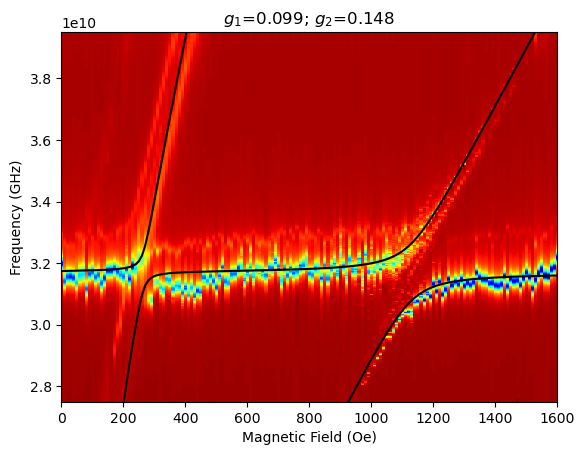

In [13]:
#Numerical calculations of dispersion spectra for case-1 (J > Γ)
initial_params = [g1n,g2n]

# occupationList = main_calc_real_part_full(Hlist,initial_params...)
occupationList = main_calc_real_part_full(Hlist,optimized_params...)

using PyPlot
pcolormesh(Hlist, frequencies, s21, cmap=:jet)
plot(Hlist,occupationList[:,1],"k");plot(Hlist,occupationList[:,2],"k");plot(Hlist,occupationList[:,3],"k");
# plot(Hlist, locs[:,1], "bo", markersize=.7);plot(Hlist, locs[:,2], "bo", markersize=.7);
xlabel("Magnetic Field (Oe)"); ylabel("Frequency (GHz)")

# xlim(0.720, 0.920)
xlim(0, 1600)
# title(string("\$g_1\$=", round(initial_params[1], digits=3), "; \$g_2\$=", round(initial_params[2], digits=3)))
title(string("\$g_1\$=", round(optimized_params[1], digits=3), "; \$g_2\$=", round(optimized_params[2], digits=3)))
# title(string("Optimized Parameters: ", optimized_params))
ylim(2.75e10, 3.95e10)
root = "C:\\Users\\freak\\OneDrive\\Documents\\core\\Projects\\cavityCoupling\\results\\fitted";
# savefig(joinpath(root,"$type.png"))
